In [13]:
import pandas as pd
import numpy as np
import pickle
import os

import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

import shap
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, Normalizer
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn import metrics
import lightgbm as lgb
from catboost import CatBoostClassifier, Pool

In [2]:
with open('./Data/bank_EDA.pkl', 'rb') as f:
    df = pickle.load(f)
    f.close()

In [3]:
df.head()

age        job  marital    education  default housing loan    contact  \
0   56  housemaid  married     basic.4y       no      no   no  telephone   
1   57   services  married  high.school  unknown      no   no  telephone   
2   37   services  married  high.school       no     yes   no  telephone   
3   40     admin.  married     basic.6y       no      no   no  telephone   
4   56   services  married  high.school       no      no  yes  telephone   

  month day_of_week  campaign  emp.var.rate  cons.price.idx  cons.conf.idx  \
0   may         mon         1           1.1          93.994          -36.4   
1   may         mon         1           1.1          93.994          -36.4   
2   may         mon         1           1.1          93.994          -36.4   
3   may         mon         1           1.1          93.994          -36.4   
4   may         mon         1           1.1          93.994          -36.4   

   euribor3m  nr.employed  pdaysBin  previousBin  poutcomeBin  target  
0      4.857       5191.0         0            0            0       0  
1      4.857       5191.0         0            0            0       0  
2      4.857       5191.0         0            0            0       0  
3      4.857       5191.0         0            0            0       0  
4      4.857       5191.0         0            0            0       0

In [4]:
X = df.drop(columns=['target'])
y = df['target']

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.25, random_state=0)

In [6]:
X_train.head()

age         job  marital            education default housing loan  \
30566   56   housemaid  married          high.school      no     yes  yes   
37038   33      admin.  married          high.school      no      no   no   
14946   29  technician   single    university.degree      no      no  yes   
15966   27  technician   single  professional.course      no      no   no   
37481   46      admin.  married    university.degree      no     yes   no   

         contact month day_of_week  campaign  emp.var.rate  cons.price.idx  \
30566  telephone   may         mon         3          -1.8          92.893   
37038  telephone   jul         tue         1          -2.9          92.469   
14946  telephone   jul         wed         7           1.4          93.918   
15966   cellular   jul         mon         3           1.4          93.918   
37481   cellular   aug         thu         1          -2.9          92.201   

       cons.conf.idx  euribor3m  nr.employed  pdaysBin  previousBin  \
30566          -46.2      1.354       5099.1         0            1   
37038          -33.6      1.044       5076.2         0            0   
14946          -42.7      4.957       5228.1         0            0   
15966          -42.7      4.960       5228.1         0            0   
37481          -31.4      0.873       5076.2         0            0   

       poutcomeBin  
30566            0  
37038            0  
14946            0  
15966            0  
37481            0

## 3. Data Preprocessing & Feature Engineering<br>
### 3.1. Baseline Model & Feature Importance

In [ ]:
def log_loss(m, X, y):
    return metrics.log_loss(y, m.predict_proba(X)[:, 1])

def permutation_importance(model, X, y, metric):
    baseline = metric(model, X, y)
    importances = []
    
    for col in X.columns:
        save = X[col].copy()
        X[col] = np.random.permutation(X[col])
        m = metric(model, X, y)
        X[col] = save
        importances.append(m - baseline)
    
    return np.array(importances)

def baseline_importance(model, X, y, X_test, y_test, metric):
    
    model = CatBoostClassifier(one_hot_max_size=10, iterations=500)
    model.fit(X, y, cat_features=categorical_features_indices, verbose=False)
    baseline = metric(model, X_test, y_test)
    importances = []
    
    for col in X.columns:
        save = X[col].copy()
        X[col] = np.random.permutation(X[col])
        
        model.fit(X, y, cat_features=categorical_features_indices, verbose=False)
        m = metric(model, X_test, y_test)
        X[col] = save
        importances.append(m - baseline)
        
    return np.array(importances)

In [7]:
cat_features = [1, 2, 3, 4, 5, 6, 7, 8, 9, 16, 17, 18]
X.iloc[:, cat_features]

job  marital            education  default housing loan  \
0        housemaid  married             basic.4y       no      no   no   
1         services  married          high.school  unknown      no   no   
2         services  married          high.school       no     yes   no   
3           admin.  married             basic.6y       no      no   no   
4         services  married          high.school       no      no  yes   
...            ...      ...                  ...      ...     ...  ...   
41183      retired  married  professional.course       no     yes   no   
41184  blue-collar  married  professional.course       no      no   no   
41185      retired  married    university.degree       no     yes   no   
41186   technician  married  professional.course       no      no   no   
41187      retired  married  professional.course       no     yes   no   

         contact month day_of_week  pdaysBin  previousBin  poutcomeBin  
0      telephone   may         mon         0            0            0  
1      telephone   may         mon         0            0            0  
2      telephone   may         mon         0            0            0  
3      telephone   may         mon         0            0            0  
4      telephone   may         mon         0            0            0  
...          ...   ...         ...       ...          ...          ...  
41183   cellular   nov         fri         0            0            0  
41184   cellular   nov         fri         0            0            0  
41185   cellular   nov         fri         0            0            0  
41186   cellular   nov         fri         0            0            0  
41187   cellular   nov         fri         0            1            0  

[41188 rows x 12 columns]

In [8]:
clf = CatBoostClassifier(
    iterations=5,
    learning_rate=0.1,
    loss_function='Logloss',
    eval_metric='AUC',
    verbose=False
)

clf.fit(X_train, y_train,
        cat_features=cat_features,
        eval_set=(X_valid, y_valid),
        verbose=False,
        plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [11]:
shap.initjs()
explainer = shap.TreeExplainer(clf)

In [14]:
shap_values = explainer.shap_values(Pool(X_train, y_train, cat_features=cat_features))
shap.force_plot(explainer.expected_value, shap_values[0, :], X_train.iloc[0, :])

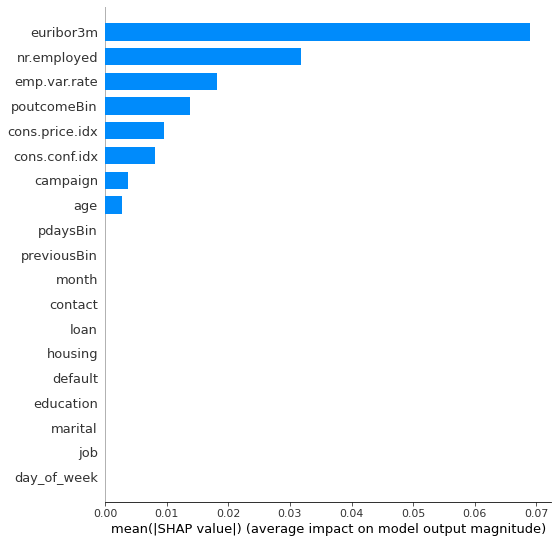

In [15]:
shap.summary_plot(shap_values, X_train, plot_type="bar")

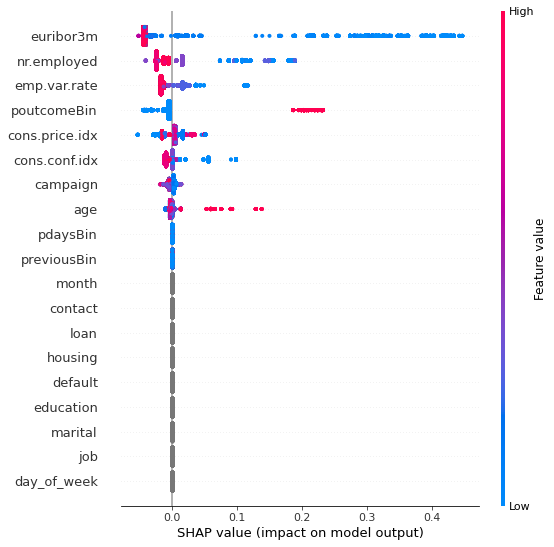

In [16]:
shap.summary_plot(shap_values, X_train)

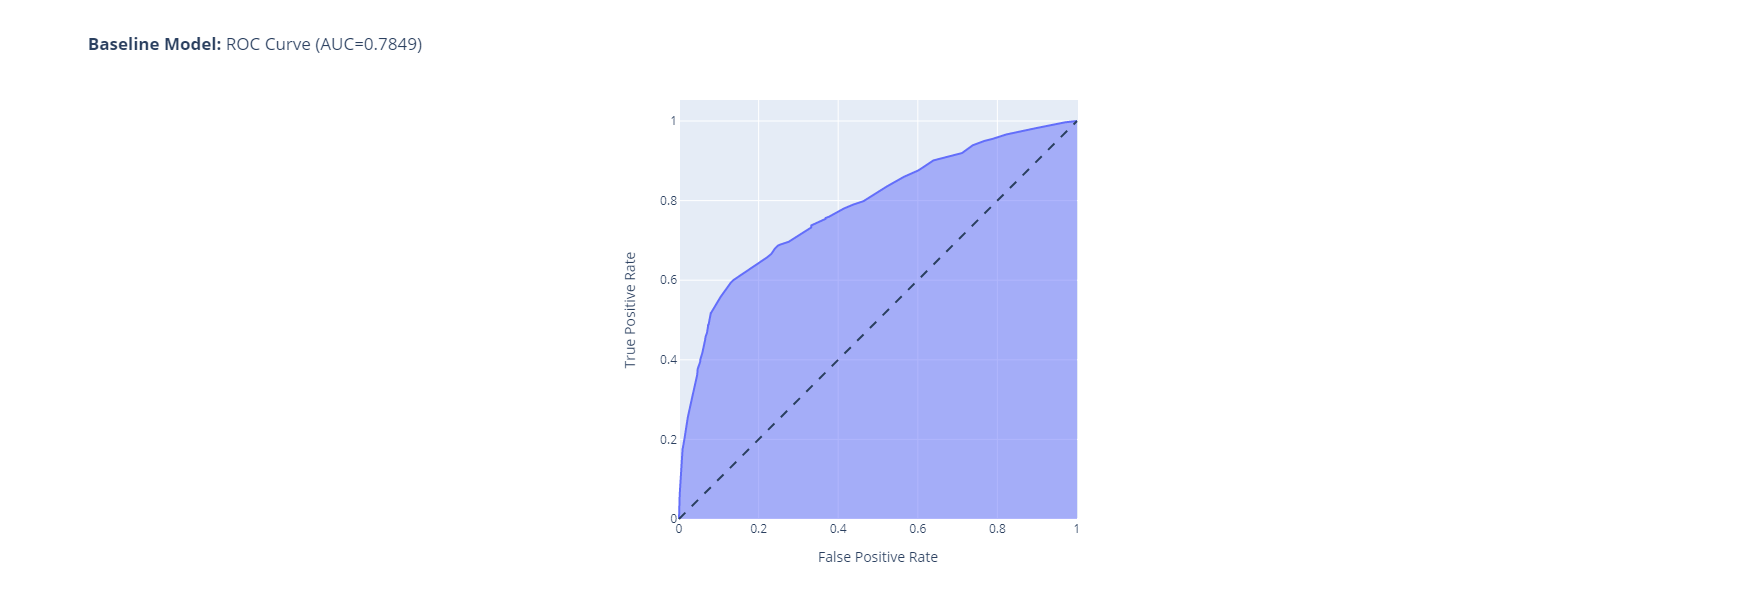

In [17]:
y_score = clf.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_score)

fig = px.area(
    x=fpr, y=tpr,
    title=f'<b>Baseline Model:</b> ROC Curve (AUC={auc(fpr, tpr):.4f})',
    labels=dict(x='False Positive Rate', y='True Positive Rate'),
    width=600, height=600
)
fig.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=0, y1=1
)

fig.update_yaxes(scaleanchor="x", scaleratio=1)
fig.update_xaxes(constrain='domain')
fig.show()

In [20]:
y_pred = clf.predict(X_test)

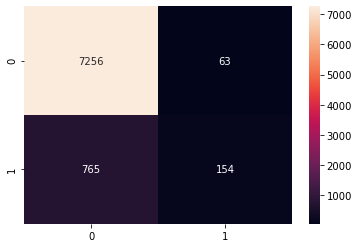

In [21]:
sns.heatmap(confusion_matrix(y_test, clf.predict(X_test)), fmt='d', annot=True)
plt.show()

In [22]:
clf.score(X_test, y_test)

0.8994901675163874

### 3.2. Scaling

In [23]:
num_features = [0, 10, 11, 12, 13, 14, 15]
X_train.iloc[:, num_features]

age  campaign  emp.var.rate  cons.price.idx  cons.conf.idx  euribor3m  \
30566   56         3          -1.8          92.893          -46.2      1.354   
37038   33         1          -2.9          92.469          -33.6      1.044   
14946   29         7           1.4          93.918          -42.7      4.957   
15966   27         3           1.4          93.918          -42.7      4.960   
37481   46         1          -2.9          92.201          -31.4      0.873   
...    ...       ...           ...             ...            ...        ...   
18246   23         5           1.4          93.918          -42.7      4.963   
31123   34         1          -1.8          92.893          -46.2      1.334   
36481   53         1          -2.9          92.963          -40.8      1.260   
32576   45         1          -1.8          92.893          -46.2      1.299   
14936   29         6           1.4          93.918          -42.7      4.957   

       nr.employed  
30566       5099.1  
37038       5076.2  
14946       5228.1  
15966       5228.1  
37481       5076.2  
...            ...  
18246       5228.1  
31123       5099.1  
36481       5076.2  
32576       5099.1  
14936       5228.1  

[24712 rows x 7 columns]

In [35]:
scaler = Normalizer()

X_train_scaled = pd.concat([pd.DataFrame(scaler.fit_transform(X_train.iloc[:, num_features])), X_train.iloc[:, cat_features].reset_index(drop=True)], axis=1)
X_test_scaled = pd.concat([pd.DataFrame(scaler.transform(X_test.iloc[:, num_features])), X_test.iloc[:, cat_features].reset_index(drop=True)], axis=1)
X_valid_scaled = pd.concat([pd.DataFrame(scaler.transform(X_valid.iloc[:, num_features])), X_valid.iloc[:, cat_features].reset_index(drop=True)], axis=1)

In [36]:
X_train_scaled

0         1         2         3         4         5         6  \
0      0.010979  0.000588 -0.000353  0.018213 -0.009058  0.000265  0.999733   
1      0.006500  0.000197 -0.000571  0.018212 -0.006618  0.000206  0.999791   
2      0.005546  0.001339  0.000268  0.017960 -0.008166  0.000948  0.999789   
3      0.005163  0.000574  0.000268  0.017960 -0.008166  0.000949  0.999791   
4      0.009060  0.000197 -0.000571  0.018159 -0.006184  0.000172  0.999775   
...         ...       ...       ...       ...       ...       ...       ...   
24707  0.004398  0.000956  0.000268  0.017960 -0.008166  0.000949  0.999795   
24708  0.006666  0.000196 -0.000353  0.018213 -0.009058  0.000262  0.999771   
24709  0.010438  0.000197 -0.000571  0.018309 -0.008035  0.000248  0.999745   
24710  0.008823  0.000196 -0.000353  0.018213 -0.009058  0.000255  0.999754   
24711  0.005546  0.001147  0.000268  0.017960 -0.008166  0.000948  0.999789   

               job   marital            education default housing loan  \
0        housemaid   married          high.school      no     yes  yes   
1           admin.   married          high.school      no      no   no   
2       technician    single    university.degree      no      no  yes   
3       technician    single  professional.course      no      no   no   
4           admin.   married    university.degree      no     yes   no   
...            ...       ...                  ...     ...     ...  ...   
24707      student    single          high.school      no     yes   no   
24708  blue-collar   married             basic.9y      no      no  yes   
24709   technician  divorced    university.degree      no      no   no   
24710  blue-collar   married             basic.6y      no     yes   no   
24711       admin.    single    university.degree      no     yes   no   

         contact month day_of_week  pdaysBin  previousBin  poutcomeBin  
0      telephone   may         mon         0            1            0  
1      telephone   jul         tue         0            0            0  
2      telephone   jul         wed         0            0            0  
3       cellular   jul         mon         0            0            0  
4       cellular   aug         thu         0            0            0  
...          ...   ...         ...       ...          ...          ...  
24707   cellular   jul         wed         0            0            0  
24708   cellular   may         wed         0            0            0  
24709   cellular   jun         wed         0            1            0  
24710   cellular   may         mon         0            0            0  
24711  telephone   jul         wed         0            0            0  

[24712 rows x 19 columns]

In [37]:
X_valid_scaled.iloc[:, [7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]]

job  marital            education  default housing loan  \
0           admin.   single    university.degree       no     yes   no   
1           admin.  married    university.degree  unknown      no  yes   
2         services  married          high.school       no      no   no   
3           admin.  married    university.degree       no     yes   no   
4           admin.  married          high.school       no      no   no   
...            ...      ...                  ...      ...     ...  ...   
8233  entrepreneur  married    university.degree       no     yes  yes   
8234   blue-collar  married             basic.4y       no     yes   no   
8235   blue-collar   single             basic.4y  unknown     yes   no   
8236    technician  married  professional.course       no      no   no   
8237        admin.  married    university.degree       no     yes   no   

        contact month day_of_week  pdaysBin  previousBin  poutcomeBin  
0      cellular   may         fri         0            1            0  
1      cellular   jul         wed         0            0            0  
2      cellular   jul         thu         0            0            0  
3      cellular   may         wed         0            0            0  
4     telephone   may         mon         0            0            0  
...         ...   ...         ...       ...          ...          ...  
8233  telephone   jun         thu         0            0            0  
8234   cellular   nov         thu         0            0            0  
8235   cellular   may         fri         0            1            0  
8236  telephone   jul         thu         0            0            0  
8237   cellular   aug         fri         0            0            0  

[8238 rows x 12 columns]

In [38]:
clf = CatBoostClassifier(
    iterations=5,
    learning_rate=0.1,
    loss_function='Logloss',
    eval_metric='AUC',
    verbose=False
)

clf.fit(X_train_scaled, y_train,
        cat_features=[7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18],
        eval_set=(X_valid_scaled, y_valid),
        verbose=False,
        plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [39]:
shap.initjs()
explainer = shap.TreeExplainer(clf)

shap_values = explainer.shap_values(Pool(X_train_scaled, y_train, cat_features=[7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]))
shap.force_plot(explainer.expected_value, shap_values[0, :], X_train_scaled.iloc[0, :])

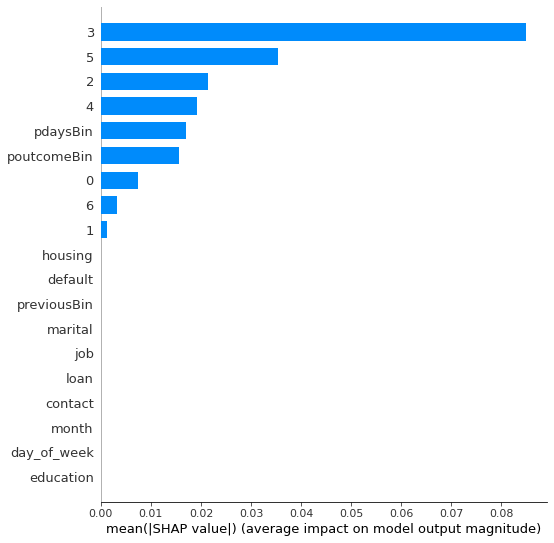

In [40]:
shap.summary_plot(shap_values, X_train_scaled, plot_type="bar")

In [41]:
X_train.iloc[:, num_features].head()

age  campaign  emp.var.rate  cons.price.idx  cons.conf.idx  euribor3m  \
30566   56         3          -1.8          92.893          -46.2      1.354   
37038   33         1          -2.9          92.469          -33.6      1.044   
14946   29         7           1.4          93.918          -42.7      4.957   
15966   27         3           1.4          93.918          -42.7      4.960   
37481   46         1          -2.9          92.201          -31.4      0.873   

       nr.employed  
30566       5099.1  
37038       5076.2  
14946       5228.1  
15966       5228.1  
37481       5076.2

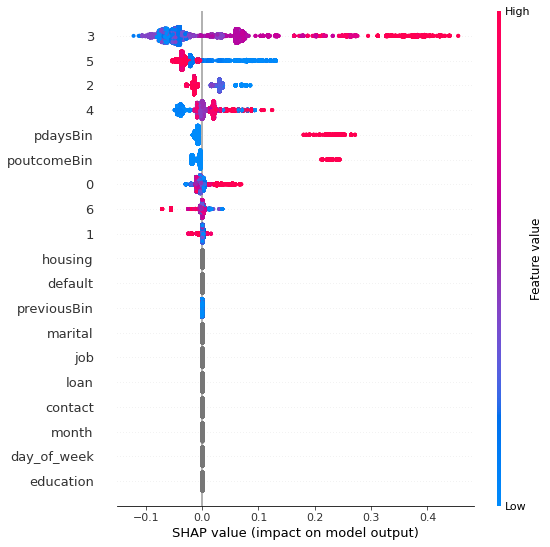

In [42]:
shap.summary_plot(shap_values, X_train_scaled)

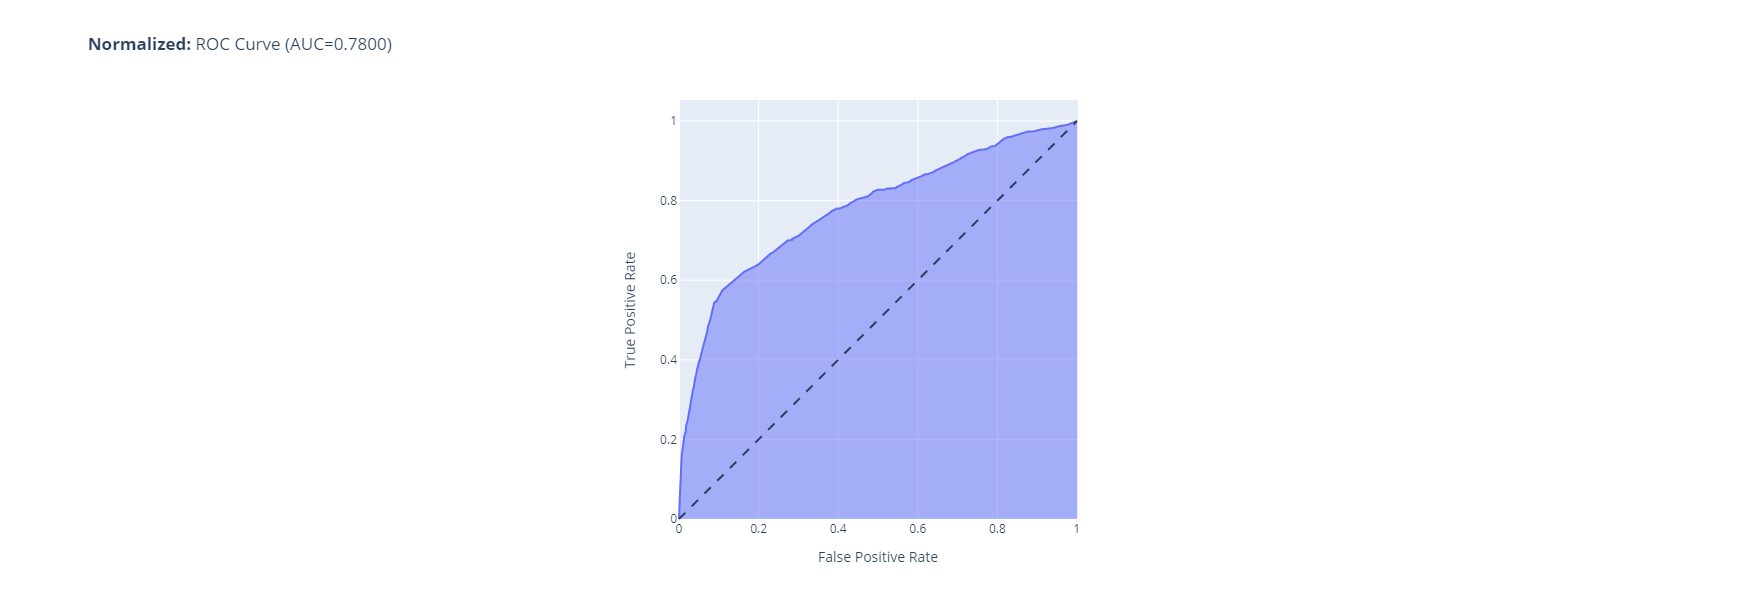

In [45]:
y_score = clf.predict_proba(X_test_scaled)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_score)

fig = px.area(
    x=fpr, y=tpr,
    title=f'<b>Normalized:</b> ROC Curve (AUC={auc(fpr, tpr):.4f})',
    labels=dict(x='False Positive Rate', y='True Positive Rate'),
    width=600, height=600
)
fig.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=0, y1=1
)

fig.update_yaxes(scaleanchor="x", scaleratio=1)
fig.update_xaxes(constrain='domain')
fig.show()

In [49]:
clf.score(X_test_scaled, y_test)

0.9000971109492595

In [48]:
clf.score(X_valid_scaled, y_test)

0.8676863316338917

In [51]:
clf.score(X_train_scaled, y_train)

0.8997248300420848

In [53]:
df.drop(columns=['default'])

age          job  marital            education housing loan    contact  \
0       56    housemaid  married             basic.4y      no   no  telephone   
1       57     services  married          high.school      no   no  telephone   
2       37     services  married          high.school     yes   no  telephone   
3       40       admin.  married             basic.6y      no   no  telephone   
4       56     services  married          high.school      no  yes  telephone   
...    ...          ...      ...                  ...     ...  ...        ...   
41183   73      retired  married  professional.course     yes   no   cellular   
41184   46  blue-collar  married  professional.course      no   no   cellular   
41185   56      retired  married    university.degree     yes   no   cellular   
41186   44   technician  married  professional.course      no   no   cellular   
41187   74      retired  married  professional.course     yes   no   cellular   

      month day_of_week  campaign  emp.var.rate  cons.price.idx  \
0       may         mon         1           1.1          93.994   
1       may         mon         1           1.1          93.994   
2       may         mon         1           1.1          93.994   
3       may         mon         1           1.1          93.994   
4       may         mon         1           1.1          93.994   
...     ...         ...       ...           ...             ...   
41183   nov         fri         1          -1.1          94.767   
41184   nov         fri         1          -1.1          94.767   
41185   nov         fri         2          -1.1          94.767   
41186   nov         fri         1          -1.1          94.767   
41187   nov         fri         3          -1.1          94.767   

       cons.conf.idx  euribor3m  nr.employed  pdaysBin  previousBin  \
0              -36.4      4.857       5191.0         0            0   
1              -36.4      4.857       5191.0         0            0   
2              -36.4      4.857       5191.0         0            0   
3              -36.4      4.857       5191.0         0            0   
4              -36.4      4.857       5191.0         0            0   
...              ...        ...          ...       ...          ...   
41183          -50.8      1.028       4963.6         0            0   
41184          -50.8      1.028       4963.6         0            0   
41185          -50.8      1.028       4963.6         0            0   
41186          -50.8      1.028       4963.6         0            0   
41187          -50.8      1.028       4963.6         0            1   

       poutcomeBin  target  
0                0       0  
1                0       0  
2                0       0  
3                0       0  
4                0       0  
...            ...     ...  
41183            0       1  
41184            0       0  
41185            0       0  
41186            0       1  
41187            0       0  

[41188 rows x 19 columns]

In [63]:
drop_idx = df[(df['job'] == 'unknown') | (df['marital'] == 'unknown') | (df['education'] == 'unknown') | (df['housing'] == 'unknown') | (df['loan'] == 'unknown')].index
df = df.drop(df.index[drop_idx])

In [64]:
df.drop(columns=['default'], inplace=True)

In [70]:
df

age          job  marital            education housing loan    contact  \
0       56    housemaid  married             basic.4y      no   no  telephone   
1       57     services  married          high.school      no   no  telephone   
2       37     services  married          high.school     yes   no  telephone   
3       40       admin.  married             basic.6y      no   no  telephone   
4       56     services  married          high.school      no  yes  telephone   
...    ...          ...      ...                  ...     ...  ...        ...   
41183   73      retired  married  professional.course     yes   no   cellular   
41184   46  blue-collar  married  professional.course      no   no   cellular   
41185   56      retired  married    university.degree     yes   no   cellular   
41186   44   technician  married  professional.course      no   no   cellular   
41187   74      retired  married  professional.course     yes   no   cellular   

      month day_of_week  campaign  emp.var.rate  cons.price.idx  \
0       may         mon         1           1.1          93.994   
1       may         mon         1           1.1          93.994   
2       may         mon         1           1.1          93.994   
3       may         mon         1           1.1          93.994   
4       may         mon         1           1.1          93.994   
...     ...         ...       ...           ...             ...   
41183   nov         fri         1          -1.1          94.767   
41184   nov         fri         1          -1.1          94.767   
41185   nov         fri         2          -1.1          94.767   
41186   nov         fri         1          -1.1          94.767   
41187   nov         fri         3          -1.1          94.767   

       cons.conf.idx  euribor3m  nr.employed  pdaysBin  previousBin  \
0              -36.4      4.857       5191.0         0            0   
1              -36.4      4.857       5191.0         0            0   
2              -36.4      4.857       5191.0         0            0   
3              -36.4      4.857       5191.0         0            0   
4              -36.4      4.857       5191.0         0            0   
...              ...        ...          ...       ...          ...   
41183          -50.8      1.028       4963.6         0            0   
41184          -50.8      1.028       4963.6         0            0   
41185          -50.8      1.028       4963.6         0            0   
41186          -50.8      1.028       4963.6         0            0   
41187          -50.8      1.028       4963.6         0            1   

       poutcomeBin  target  
0                0       0  
1                0       0  
2                0       0  
3                0       0  
4                0       0  
...            ...     ...  
41183            0       1  
41184            0       0  
41185            0       0  
41186            0       1  
41187            0       0  

[38245 rows x 19 columns]